In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

JUPYTER_PATH = Path.cwd()
PROJECT_ROOT = JUPYTER_PATH.parents[0]
os.chdir(PROJECT_ROOT)
print(f"Main Project Root: {os.getcwd()}")

Main Project Root: /Users/mungughyeon/Documents/contest/DACON_BDA


In [2]:
train_path = PROJECT_ROOT / "dataset/train.csv"
test_path = PROJECT_ROOT / "dataset/test.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(f"Train Dataset: {train.shape}")
print(f"Test Dataset: {test.shape}")

Train Dataset: (748, 46)
Test Dataset: (814, 45)


## BaseLine

In [3]:
from src.preprocess import Pipeline

pipe = Pipeline(config={'skip_steps': ['create_features', 'encode_text_embeddings']})
tr, te, tid = pipe.run(train, test)

X = tr.drop(columns=['completed'])
y = tr['completed']

[fill_na] 결측치 처리 완료
[fix_completed_semester] completed_semester 처리 완료
[map_major] major 매핑 완료 (test only)
[drop_useless] ['generation', 'contest_award', 'idea_contest', 'contest_participation'] 제거 완료
[encode_certs] 자격증 인코딩 완료
[encode_companies] 기업 카테고리 인코딩 완료
[encode_multi_hot] multi-hot 인코딩 완료
[encode_text_embeddings] 건너뜀
[drop_originals] 원본 컬럼 제거 완료
[create_features] 건너뜀
Preprocessing completed: train (748, 102), test (814, 101)


In [4]:
from src.models import ModelComparator

comparator = ModelComparator(n_splits=10)
results = comparator.run(X, y, pipeline=pipe)
results

LightGBM: 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


  → LightGBM: OOF F1=0.4657, Mean Fold F1=0.4786±0.0313, Threshold=0.28


XGBoost: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


  → XGBoost: OOF F1=0.3846, Mean Fold F1=0.4125±0.0593, Threshold=0.12


CatBoost: 100%|██████████| 10/10 [00:02<00:00,  4.60it/s]


  → CatBoost: OOF F1=0.4696, Mean Fold F1=0.4828±0.0293, Threshold=0.4


RandomForest: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


  → RandomForest: OOF F1=0.4607, Mean Fold F1=0.4938±0.0267, Threshold=0.13


ExtraTrees: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]

  → ExtraTrees: OOF F1=0.463, Mean Fold F1=0.4933±0.0233, Threshold=0.27


,name,oof_f1,mean_fold_f1,std_fold_f1,best_threshold
0,CatBoost,0.4696,0.4828,0.0293,0.40
1,LightGBM,0.4657,0.4786,0.0313,0.28
2,ExtraTrees,0.4630,0.4933,0.0233,0.27
3,RandomForest,0.4607,0.4938,0.0267,0.13
4,XGBoost,0.3846,0.4125,0.0593,0.12


### Feature Importance

In [5]:
def feature_importance(
    comparator,
    X,
    model_indices,
    model_names,
    top_n=20,
    bottom_n=30
):
    imp_dfs = {}
    for i, name in zip(model_indices, model_names):
        m = comparator.models[i].models[0]
        imp = m.get_feature_importance() if name == 'CatBoost' else m.feature_importances_

        imp_dfs[name] = (
            pd.DataFrame({
                'feature': X.columns,
                'importance': imp
            })
            .sort_values('importance', ascending=False)
            .reset_index(drop=True)
        )

    top_sets = {name: set(df.head(top_n)['feature']) for name, df in imp_dfs.items()}
    bottom_sets = {name: set(df.tail(bottom_n)['feature']) for name, df in imp_dfs.items()}
    zero_sets = {name: set(df[df['importance'] == 0]['feature']) for name, df in imp_dfs.items()}

    top_common = set.intersection(*top_sets.values())
    bottom_common = set.intersection(*bottom_sets.values())
    zero_common = set.intersection(*zero_sets.values())
    rows = []

    for f in sorted(top_common):
        row = {'feature': f, 'group': f"Top_{top_n}"}
        for name, df in imp_dfs.items():
            row[name] = df.loc[df['feature'] == f, 'importance'].values[0]
        rows.append(row)

    for f in sorted(bottom_common):
        row = {'feature': f, 'group': f"Bottom_{bottom_n}"}
        for name, df in imp_dfs.items():
            row[name] = df.loc[df['feature'] == f, 'importance'].values[0]
        rows.append(row)

    for f in sorted(zero_common):
        row = {'feature': f, 'group': "Importance_0"}
        for name, df in imp_dfs.items():
            row[name] = df.loc[df['feature'] == f, 'importance'].values[0]
        rows.append(row)

    result_df = pd.DataFrame(rows)
    return result_df, imp_dfs

In [6]:
top3 = ['CatBoost', 'LightGBM', 'ExtraTrees']
top3_idx = [2, 0, 4]

common_df, imp_dfs = feature_importance(
    comparator=comparator,
    X=X,
    model_indices=top3_idx,
    model_names=top3,
    top_n=20,
    bottom_n=30
)

common_df

,feature,group,CatBoost,LightGBM,ExtraTrees
0,cert_count,Top_20,10.738569,1,0.014310
1,dje_PM기획,Top_20,0.828380,0,0.014614
2,major1_1,Top_20,1.804944,0,0.017528
3,school1,Top_20,44.614791,5,0.107371
4,whyBDA,Top_20,7.361158,1,0.019446
5,cert_구글애널리스트,Bottom_30,0.000000,0,0.004668
6,cert_정보처리기사,Bottom_30,0.000000,0,0.002838
7,cert_컴퓨터활용능력,Bottom_30,0.000000,0,0.000597
8,cert_태블로,Bottom_30,0.000000,0,0.000411
9,class4,Bottom_30,0.000000,0,0.000000


In [7]:
import matplotlib.pyplot as plt
from src.visualization.plot import set_korean_font, bar_plot
set_korean_font()

def plot_importance(imp_dfs, model_names, top_n=20, palette='Blues_r'):
    fig, axes = plt.subplots(1, len(model_names), figsize=(8 * len(model_names), 8))

    if len(model_names) == 1:
        axes = [axes]

    for ax, name in zip(axes, model_names):
        df_top = imp_dfs[name].head(top_n).sort_values('importance', ascending=False)

        bar_plot(
            df_top,
            x_col='importance',
            y_col='feature',
            ax=ax,
            palette=palette,
            title=f'{name} Top {top_n}',
            xlabel='Importance',
            show=False
        )

    plt.tight_layout()
    plt.show()

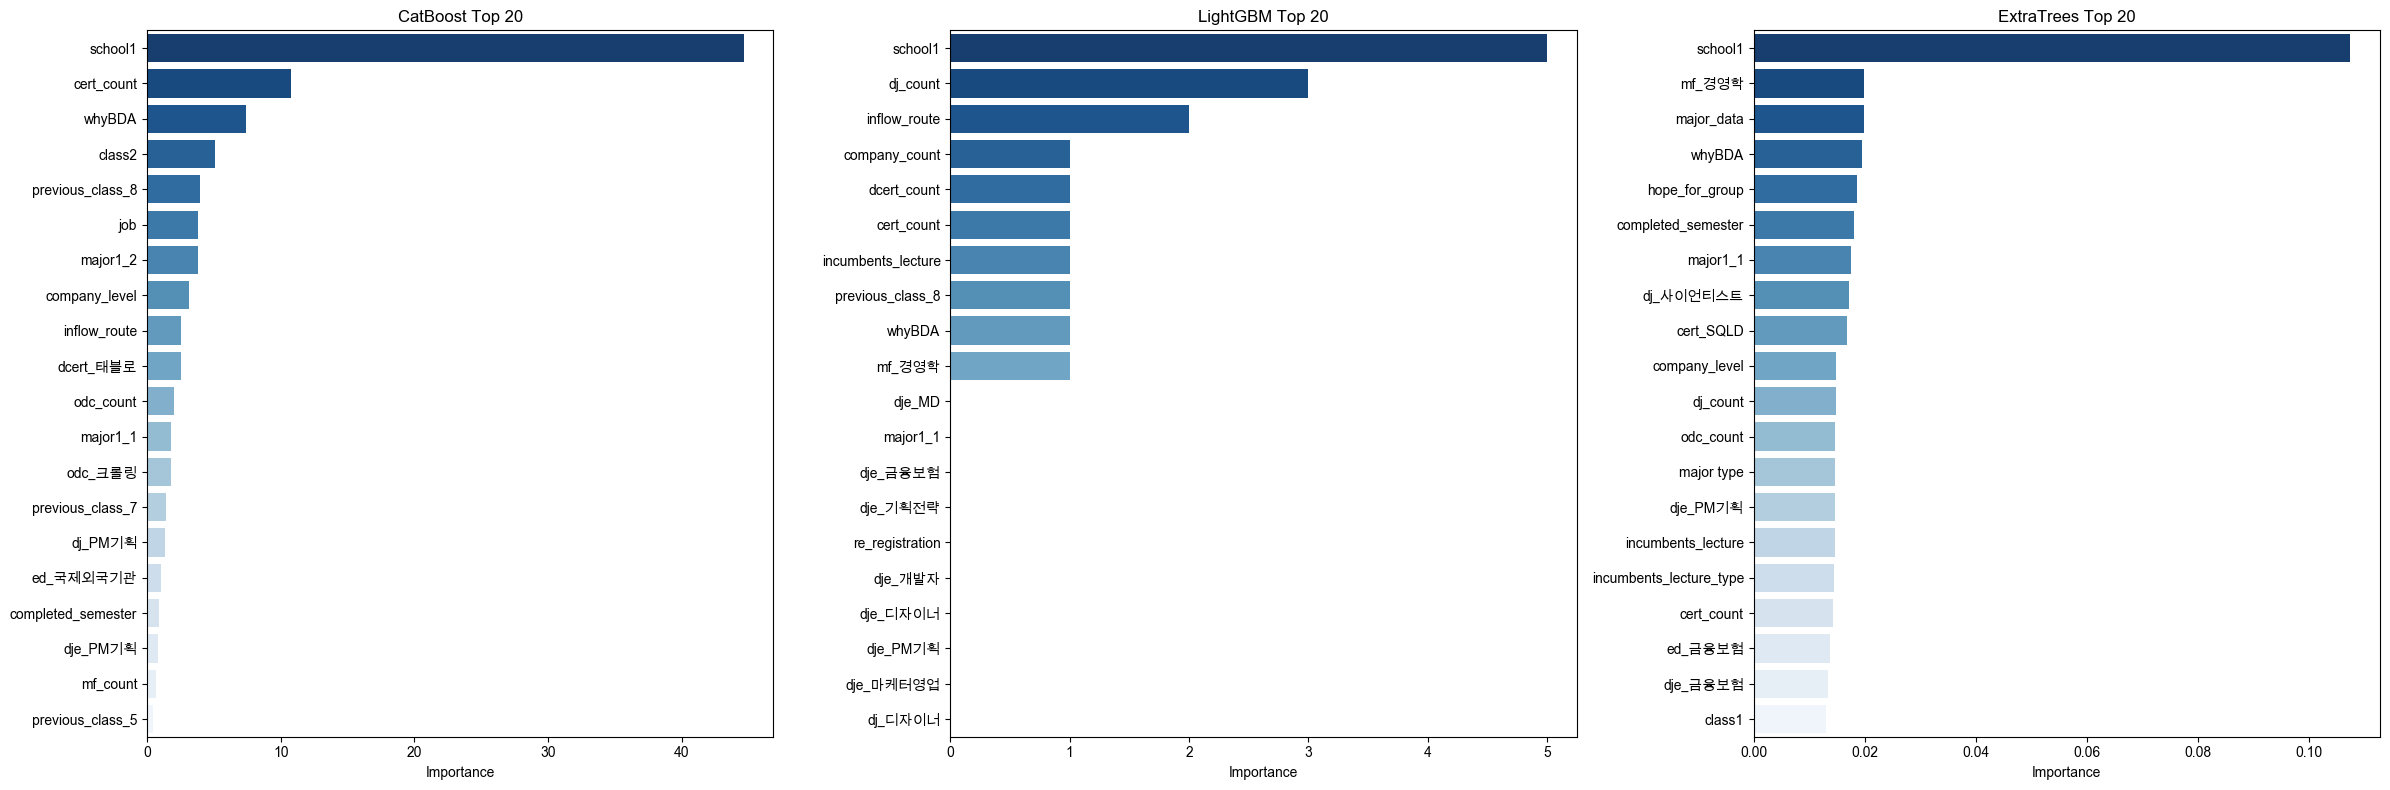

In [8]:
plot_importance(
    imp_dfs=imp_dfs,
    model_names=top3,
    top_n=20
)

### Version 1

- Delete Feature importance zero values columns: `zero_common`

In [9]:
from src.preprocess import Pipeline

pipe = Pipeline(config={'skip_steps': ['create_features', 'encode_text_embeddings']})
tr_1, te_1, tid_1 = pipe.run(train, test)

zero_common_list = common_df[common_df['group'] == 'Importance_0']['feature'].tolist()
v1_drop_cols = zero_common_list + ['completed']

X_v1 = tr_1.drop(columns=v1_drop_cols)
test_v1 = te_1.drop(columns=zero_common_list)

print(f"\nFeature: {X.shape[1]} → {X_v1.shape[1]}")
print(f"X_v1: {X_v1.shape}, y: {y.shape}, test_v1: {test_v1.shape}")

[fill_na] 결측치 처리 완료
[fix_completed_semester] completed_semester 처리 완료
[map_major] major 매핑 완료 (test only)
[drop_useless] ['generation', 'contest_award', 'idea_contest', 'contest_participation'] 제거 완료
[encode_certs] 자격증 인코딩 완료
[encode_companies] 기업 카테고리 인코딩 완료
[encode_multi_hot] multi-hot 인코딩 완료
[encode_text_embeddings] 건너뜀
[drop_originals] 원본 컬럼 제거 완료
[create_features] 건너뜀
Preprocessing completed: train (748, 102), test (814, 101)

Feature: 101 → 97
X_v1: (748, 97), y: (748,), test_v1: (814, 97)


In [10]:
comparator_v1 = ModelComparator(n_splits=10)
result_v1 = comparator_v1.run(X_v1, y, pipeline=pipe)
result_v1

LightGBM: 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


  → LightGBM: OOF F1=0.4657, Mean Fold F1=0.4786±0.0313, Threshold=0.28


XGBoost: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


  → XGBoost: OOF F1=0.4116, Mean Fold F1=0.4253±0.0484, Threshold=0.12


CatBoost: 100%|██████████| 10/10 [00:02<00:00,  4.70it/s]


  → CatBoost: OOF F1=0.4691, Mean Fold F1=0.4775±0.0317, Threshold=0.44


RandomForest: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


  → RandomForest: OOF F1=0.4676, Mean Fold F1=0.497±0.02, Threshold=0.24


ExtraTrees: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

  → ExtraTrees: OOF F1=0.4668, Mean Fold F1=0.4905±0.0193, Threshold=0.26


,name,oof_f1,mean_fold_f1,std_fold_f1,best_threshold
0,CatBoost,0.4691,0.4775,0.0317,0.44
1,RandomForest,0.4676,0.4970,0.0200,0.24
2,ExtraTrees,0.4668,0.4905,0.0193,0.26
3,LightGBM,0.4657,0.4786,0.0313,0.28
4,XGBoost,0.4116,0.4253,0.0484,0.12


In [11]:
common_df_1, imp_dfs_1 = feature_importance(
    comparator=comparator_v1,
    X=X_v1,
    model_indices=top3_idx,
    model_names=top3,
    top_n=20,
    bottom_n=30
)

common_df_1

,feature,group,CatBoost,LightGBM,ExtraTrees
0,cert_count,Top_20,9.072222,1,0.015763
1,dj_count,Top_20,0.000000,3,0.017210
2,dje_금융보험,Top_20,0.000000,0,0.013703
3,dje_기획전략,Top_20,0.000000,0,0.013606
4,school1,Top_20,42.652768,5,0.103654
5,cert_구글애널리스트,Bottom_30,0.000000,0,0.004388
6,cert_정보처리기사,Bottom_30,0.000000,0,0.003190
7,cert_컴퓨터활용능력,Bottom_30,0.000000,0,0.000752
8,cert_태블로,Bottom_30,0.000000,0,0.000240
9,class3,Bottom_30,0.000000,0,0.001206


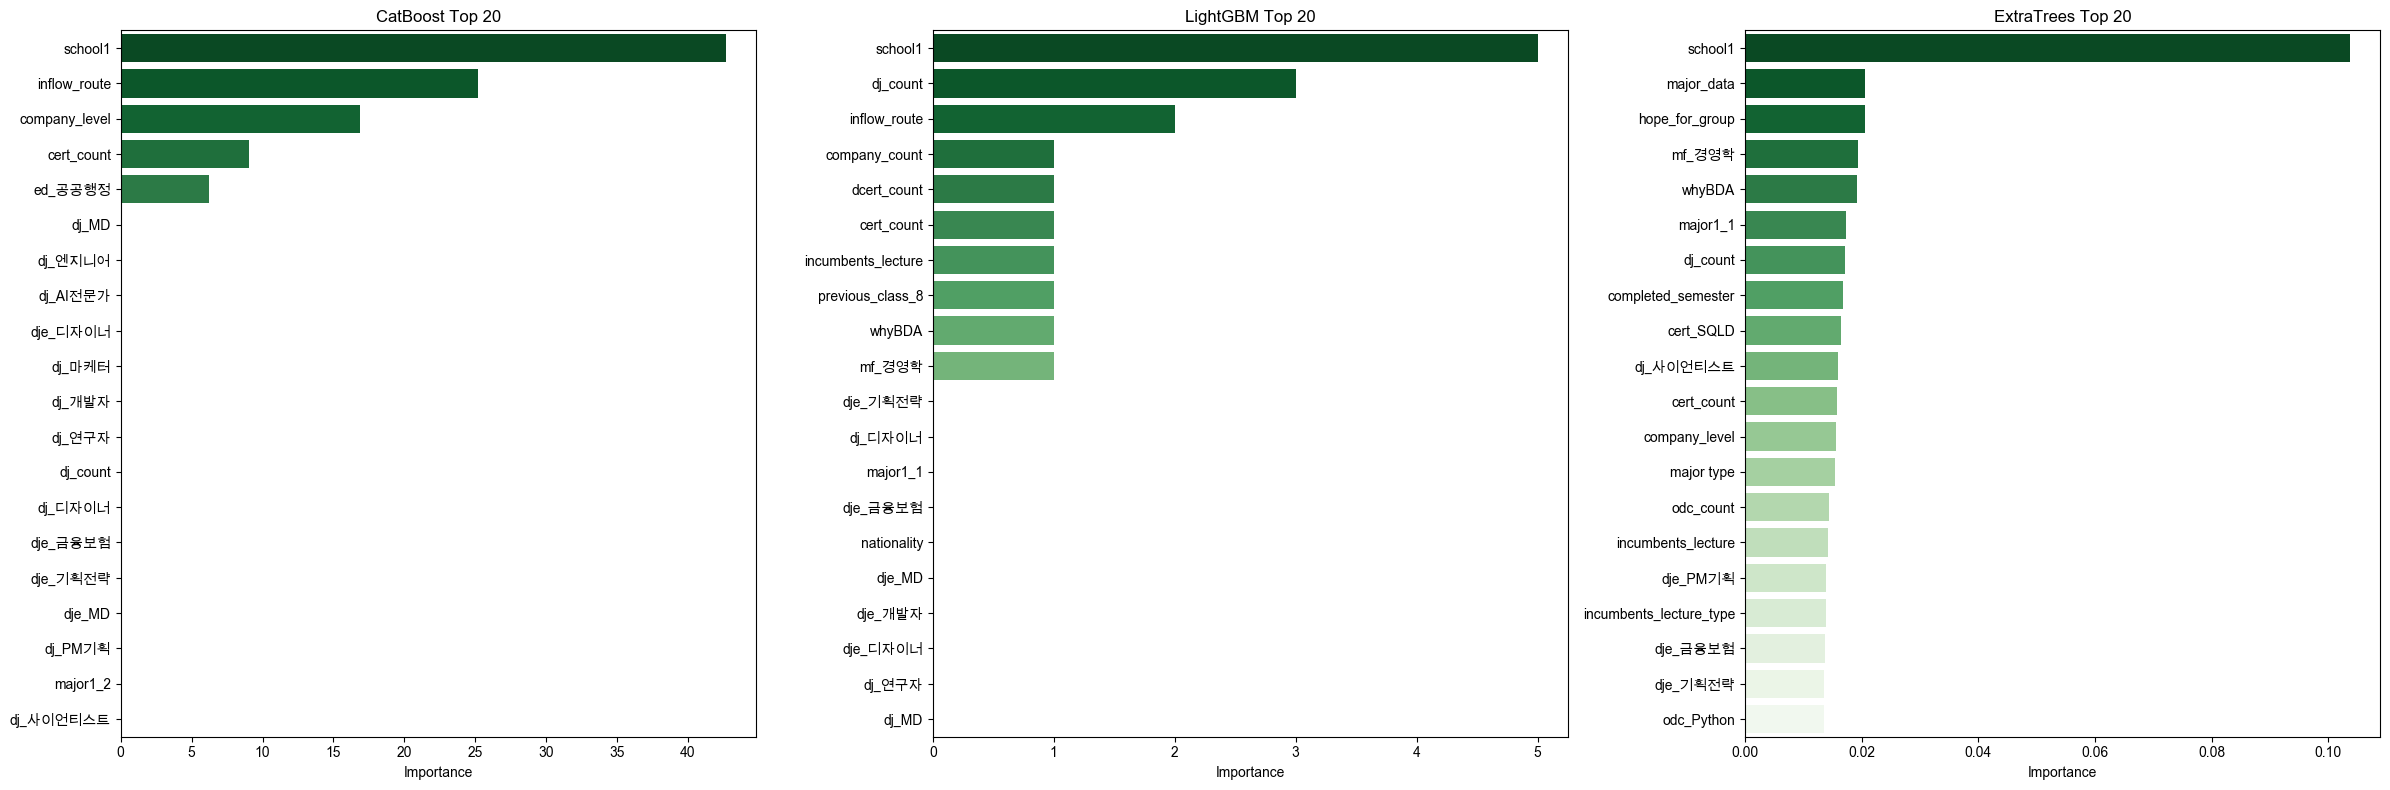

In [12]:
plot_importance(
    imp_dfs=imp_dfs_1,
    model_names=top3,
    top_n=20,
    palette='Greens_r'
)

### Version 2

- Add: Create Features

In [13]:
from src.preprocess import Pipeline

pipe = Pipeline(config={'skip_steps': ['encode_text_embeddings']})
tr_2, te_2, tid_2 = pipe.run(train, test)
X_v2 = tr_2.drop(columns=['completed'])

print(f"\nFeature: {X_v1.shape[1]} → {X_v2.shape[1]}")
print(f"X_v2: {X_v2.shape}, y: {y.shape}, test_v2: {te_2.shape}")

[fill_na] 결측치 처리 완료
[fix_completed_semester] completed_semester 처리 완료
[map_major] major 매핑 완료 (test only)
[drop_useless] ['generation', 'contest_award', 'idea_contest', 'contest_participation'] 제거 완료
[encode_certs] 자격증 인코딩 완료
[encode_companies] 기업 카테고리 인코딩 완료
[encode_multi_hot] multi-hot 인코딩 완료
[encode_text_embeddings] 건너뜀
[drop_originals] 원본 컬럼 제거 완료
[create_features] 파생변수 23개 생성 완료
Preprocessing completed: train (748, 126), test (814, 125)

Feature: 97 → 125
X_v2: (748, 125), y: (748,), test_v2: (814, 125)


In [14]:
comparator_v2 = ModelComparator(n_splits=10)
result_v2 = comparator_v2.run(X_v2, y, pipeline=pipe)
result_v2

LightGBM: 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


  → LightGBM: OOF F1=0.464, Mean Fold F1=0.4804±0.0241, Threshold=0.26


XGBoost: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


  → XGBoost: OOF F1=0.414, Mean Fold F1=0.435±0.0417, Threshold=0.11


CatBoost: 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


  → CatBoost: OOF F1=0.4707, Mean Fold F1=0.4875±0.03, Threshold=0.37


RandomForest: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


  → RandomForest: OOF F1=0.4627, Mean Fold F1=0.4984±0.025, Threshold=0.22


ExtraTrees: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s]

  → ExtraTrees: OOF F1=0.465, Mean Fold F1=0.504±0.0334, Threshold=0.25


,name,oof_f1,mean_fold_f1,std_fold_f1,best_threshold
0,CatBoost,0.4707,0.4875,0.0300,0.37
1,ExtraTrees,0.4650,0.5040,0.0334,0.25
2,LightGBM,0.4640,0.4804,0.0241,0.26
3,RandomForest,0.4627,0.4984,0.0250,0.22
4,XGBoost,0.4140,0.4350,0.0417,0.11


In [15]:
common_df_2, imp_dfs_2 = feature_importance(
    comparator=comparator_v2,
    X=X_v2,
    model_indices=top3_idx,
    model_names=top3,
    top_n=20,
    bottom_n=30
)

common_df_2

,feature,group,CatBoost,LightGBM,ExtraTrees
0,odc_count,Top_20,0.000000,2,0.011736
1,school1,Top_20,40.970348,9,0.083142
2,cert_컴퓨터활용능력,Bottom_30,0.000000,0,0.000400
3,cert_태블로,Bottom_30,0.000000,0,0.000141
4,dcert_컴퓨터활용능력,Bottom_30,0.000000,0,0.000000
5,mf_경제통상학,Bottom_30,0.000000,0,0.002917
6,mf_교육학,Bottom_30,0.000000,0,0.001770
7,mf_법학,Bottom_30,0.000000,0,0.000116
8,mf_예체능,Bottom_30,0.000000,0,0.003092
9,mf_의약학,Bottom_30,0.000000,0,0.000456


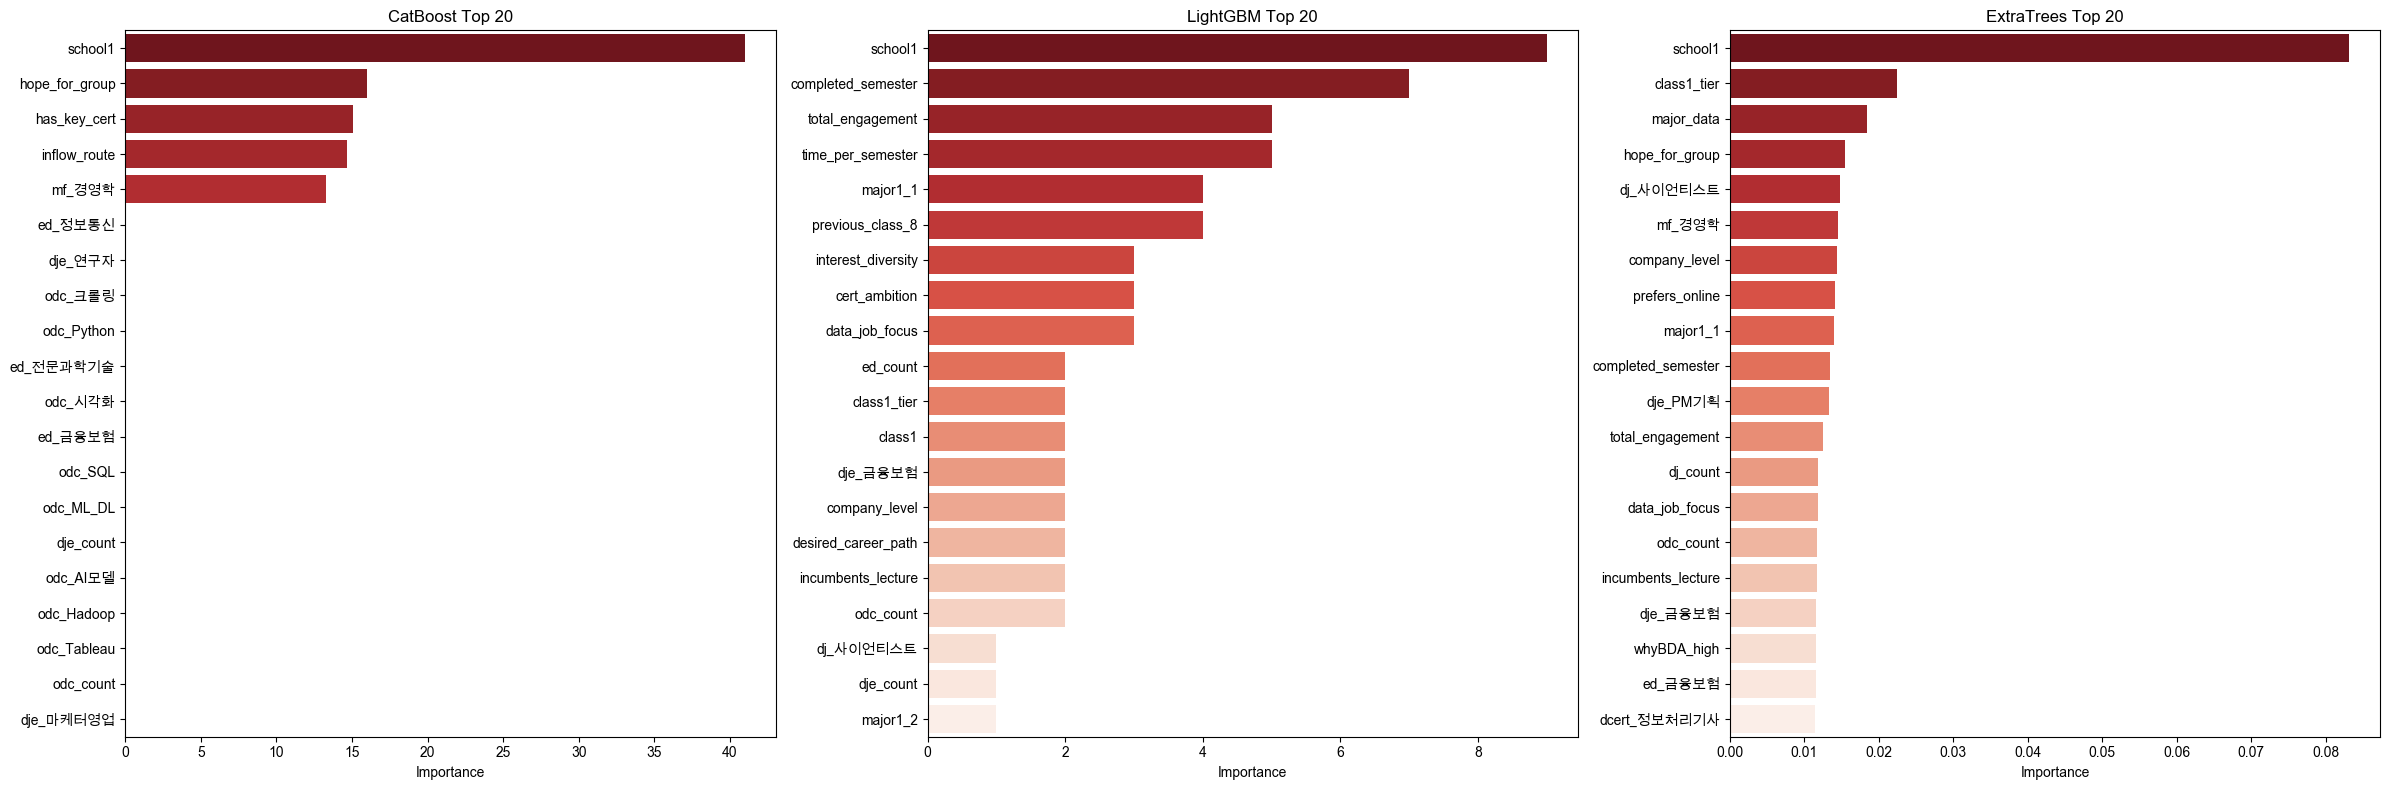

In [16]:
plot_importance(
    imp_dfs=imp_dfs_2,
    model_names=top3,
    top_n=20,
    palette='Reds_r'
)

### Version 3

- Add Create Features & Delete importance=0 columns

In [17]:
from src.preprocess import Pipeline

pipe = Pipeline(config={'skip_steps': ['encode_text_embeddings']})
tr_3, te_3, tid_3 = pipe.run(train, test)
X_v3 = tr_3.drop(columns=v1_drop_cols)
test_v3 = te_3.drop(columns=zero_common_list)

print(f"\nFeature: {X_v2.shape[1]} → {X_v3.shape[1]}")
print(f"X_v3: {X_v3.shape}, y: {y.shape}, test_v3: {test_v3.shape}")

[fill_na] 결측치 처리 완료
[fix_completed_semester] completed_semester 처리 완료
[map_major] major 매핑 완료 (test only)
[drop_useless] ['generation', 'contest_award', 'idea_contest', 'contest_participation'] 제거 완료
[encode_certs] 자격증 인코딩 완료
[encode_companies] 기업 카테고리 인코딩 완료
[encode_multi_hot] multi-hot 인코딩 완료
[encode_text_embeddings] 건너뜀
[drop_originals] 원본 컬럼 제거 완료
[create_features] 파생변수 23개 생성 완료
Preprocessing completed: train (748, 126), test (814, 125)

Feature: 125 → 121
X_v3: (748, 121), y: (748,), test_v3: (814, 121)


In [18]:
comparator_v3 = ModelComparator(n_splits=10)
result_v3 = comparator_v3.run(X_v3, y, pipeline=pipe)
result_v3

LightGBM: 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]


  → LightGBM: OOF F1=0.464, Mean Fold F1=0.4804±0.0241, Threshold=0.26


XGBoost: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


  → XGBoost: OOF F1=0.417, Mean Fold F1=0.4334±0.041, Threshold=0.2


CatBoost: 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]


  → CatBoost: OOF F1=0.4712, Mean Fold F1=0.4843±0.0346, Threshold=0.34


RandomForest: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


  → RandomForest: OOF F1=0.4615, Mean Fold F1=0.5002±0.0245, Threshold=0.2


ExtraTrees: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]

  → ExtraTrees: OOF F1=0.4642, Mean Fold F1=0.5022±0.0357, Threshold=0.24


,name,oof_f1,mean_fold_f1,std_fold_f1,best_threshold
0,CatBoost,0.4712,0.4843,0.0346,0.34
1,ExtraTrees,0.4642,0.5022,0.0357,0.24
2,LightGBM,0.4640,0.4804,0.0241,0.26
3,RandomForest,0.4615,0.5002,0.0245,0.20
4,XGBoost,0.4170,0.4334,0.0410,0.20


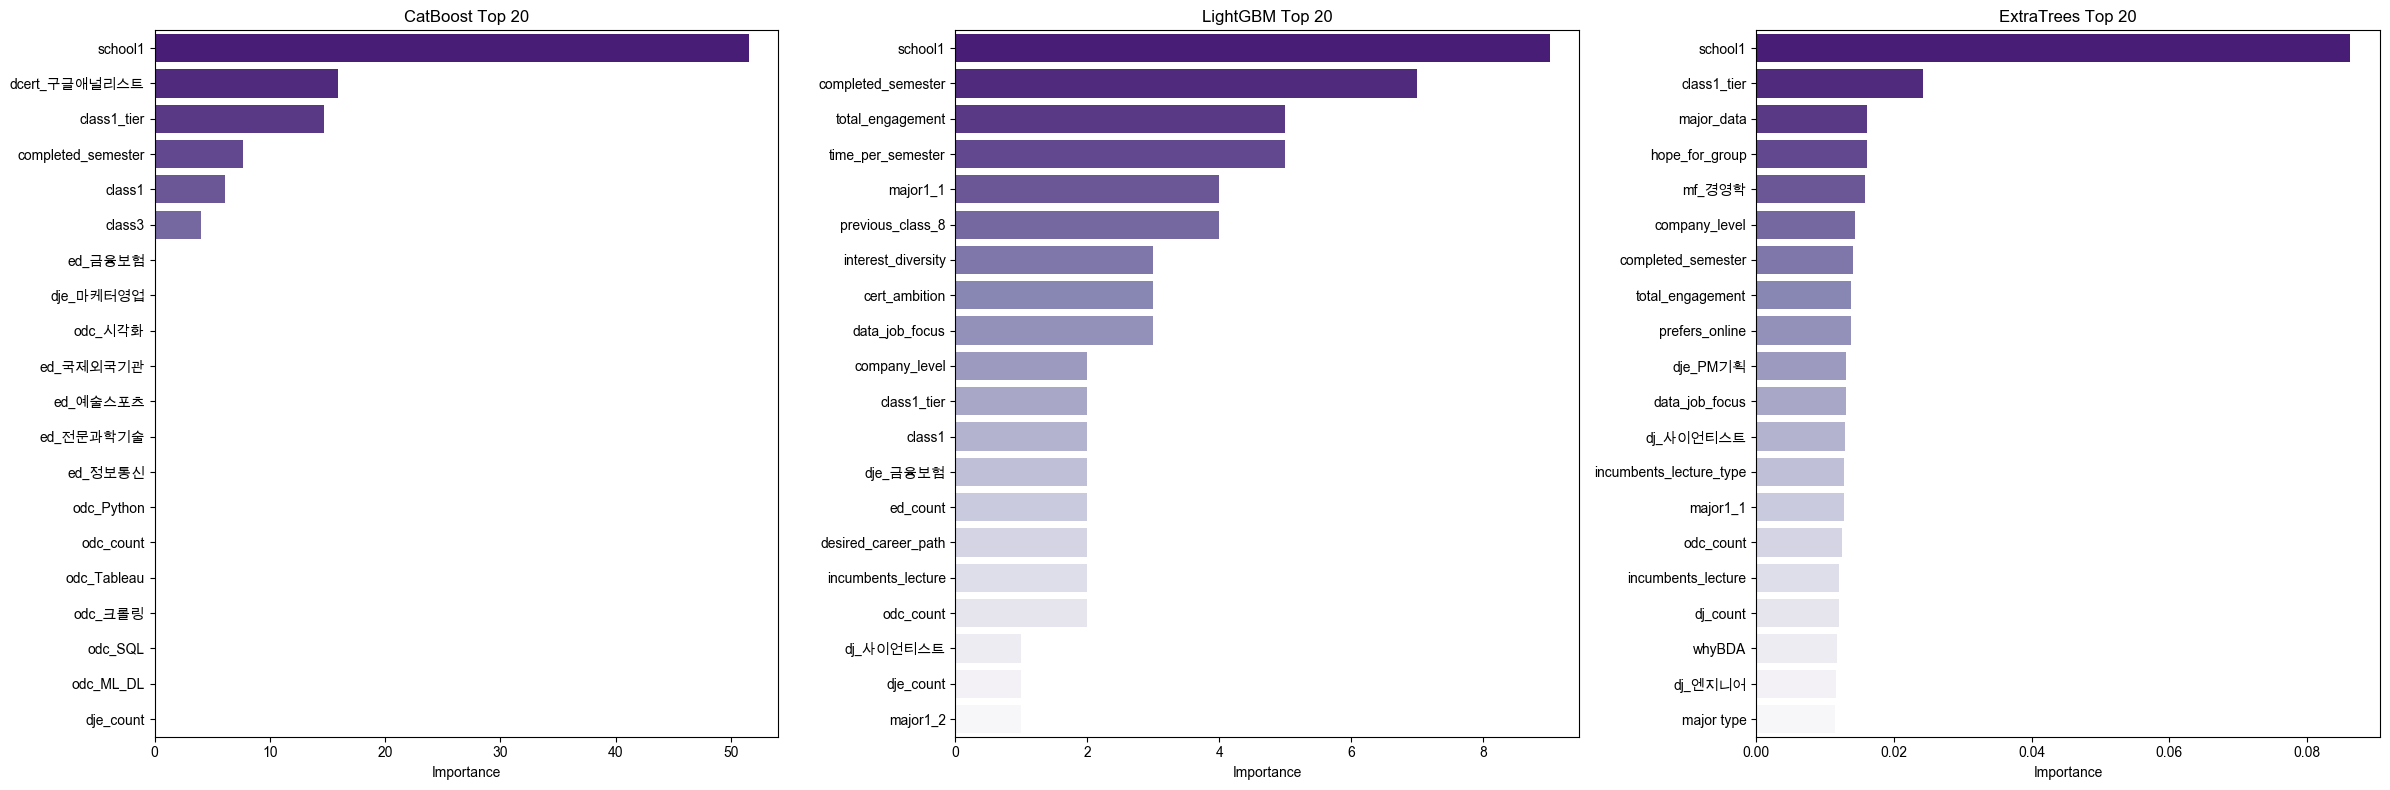

,feature,group,CatBoost,LightGBM,ExtraTrees
0,class1_tier,Top_20,14.664586,2,0.024166
1,completed_semester,Top_20,7.714289,7,0.014014
2,odc_count,Top_20,0.000000,2,0.012506
3,school1,Top_20,51.558601,9,0.086273
4,cert_컴퓨터활용능력,Bottom_30,0.000000,0,0.000290
5,cert_태블로,Bottom_30,0.000000,0,0.000140
6,mf_경제통상학,Bottom_30,0.000000,0,0.003060
7,mf_교육학,Bottom_30,0.000000,0,0.001569
8,mf_법학,Bottom_30,0.000000,0,0.000108
9,mf_예체능,Bottom_30,0.000000,0,0.002875


In [19]:
common_df_3, imp_dfs_3 = feature_importance(
    comparator=comparator_v3,
    X=X_v3,
    model_indices=top3_idx,
    model_names=top3,
    top_n=20,
    bottom_n=30
)

plot_importance(
    imp_dfs=imp_dfs_3,
    model_names=top3,
    top_n=20,
    palette='Purples_r'
)

common_df_3

### Version 4

- Delete: Importance_0: `nationality`

In [20]:
from src.preprocess import Pipeline

pipe = Pipeline(config={'skip_steps': ['encode_text_embeddings']})
tr_4, te_4, tid_4 = pipe.run(train, test)
v4_drop_cols = v1_drop_cols + ['nationality']

X_v4 = tr_4.drop(columns=v4_drop_cols)
test_v4 = te_4.drop(columns=zero_common_list + ['nationality'])

print(f"\nFeature: {X_v3.shape[1]} → {X_v4.shape[1]}")
print(f"X_v4: {X_v4.shape}, y: {y.shape}, test_v4: {test_v4.shape}")

[fill_na] 결측치 처리 완료
[fix_completed_semester] completed_semester 처리 완료
[map_major] major 매핑 완료 (test only)
[drop_useless] ['generation', 'contest_award', 'idea_contest', 'contest_participation'] 제거 완료
[encode_certs] 자격증 인코딩 완료
[encode_companies] 기업 카테고리 인코딩 완료
[encode_multi_hot] multi-hot 인코딩 완료
[encode_text_embeddings] 건너뜀
[drop_originals] 원본 컬럼 제거 완료
[create_features] 파생변수 23개 생성 완료
Preprocessing completed: train (748, 126), test (814, 125)

Feature: 121 → 120
X_v4: (748, 120), y: (748,), test_v4: (814, 120)


In [21]:
comparator_v4 = ModelComparator(n_splits=10)
result_v4 = comparator_v4.run(X_v4, y, pipeline=pipe)
result_v4

LightGBM: 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


  → LightGBM: OOF F1=0.464, Mean Fold F1=0.4804±0.0241, Threshold=0.26


XGBoost: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


  → XGBoost: OOF F1=0.3939, Mean Fold F1=0.4261±0.0486, Threshold=0.13


CatBoost: 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


  → CatBoost: OOF F1=0.4719, Mean Fold F1=0.493±0.0408, Threshold=0.39


RandomForest: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


  → RandomForest: OOF F1=0.4598, Mean Fold F1=0.5043±0.031, Threshold=0.11


ExtraTrees: 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]

  → ExtraTrees: OOF F1=0.4646, Mean Fold F1=0.4986±0.0378, Threshold=0.26


,name,oof_f1,mean_fold_f1,std_fold_f1,best_threshold
0,CatBoost,0.4719,0.4930,0.0408,0.39
1,ExtraTrees,0.4646,0.4986,0.0378,0.26
2,LightGBM,0.4640,0.4804,0.0241,0.26
3,RandomForest,0.4598,0.5043,0.0310,0.11
4,XGBoost,0.3939,0.4261,0.0486,0.13


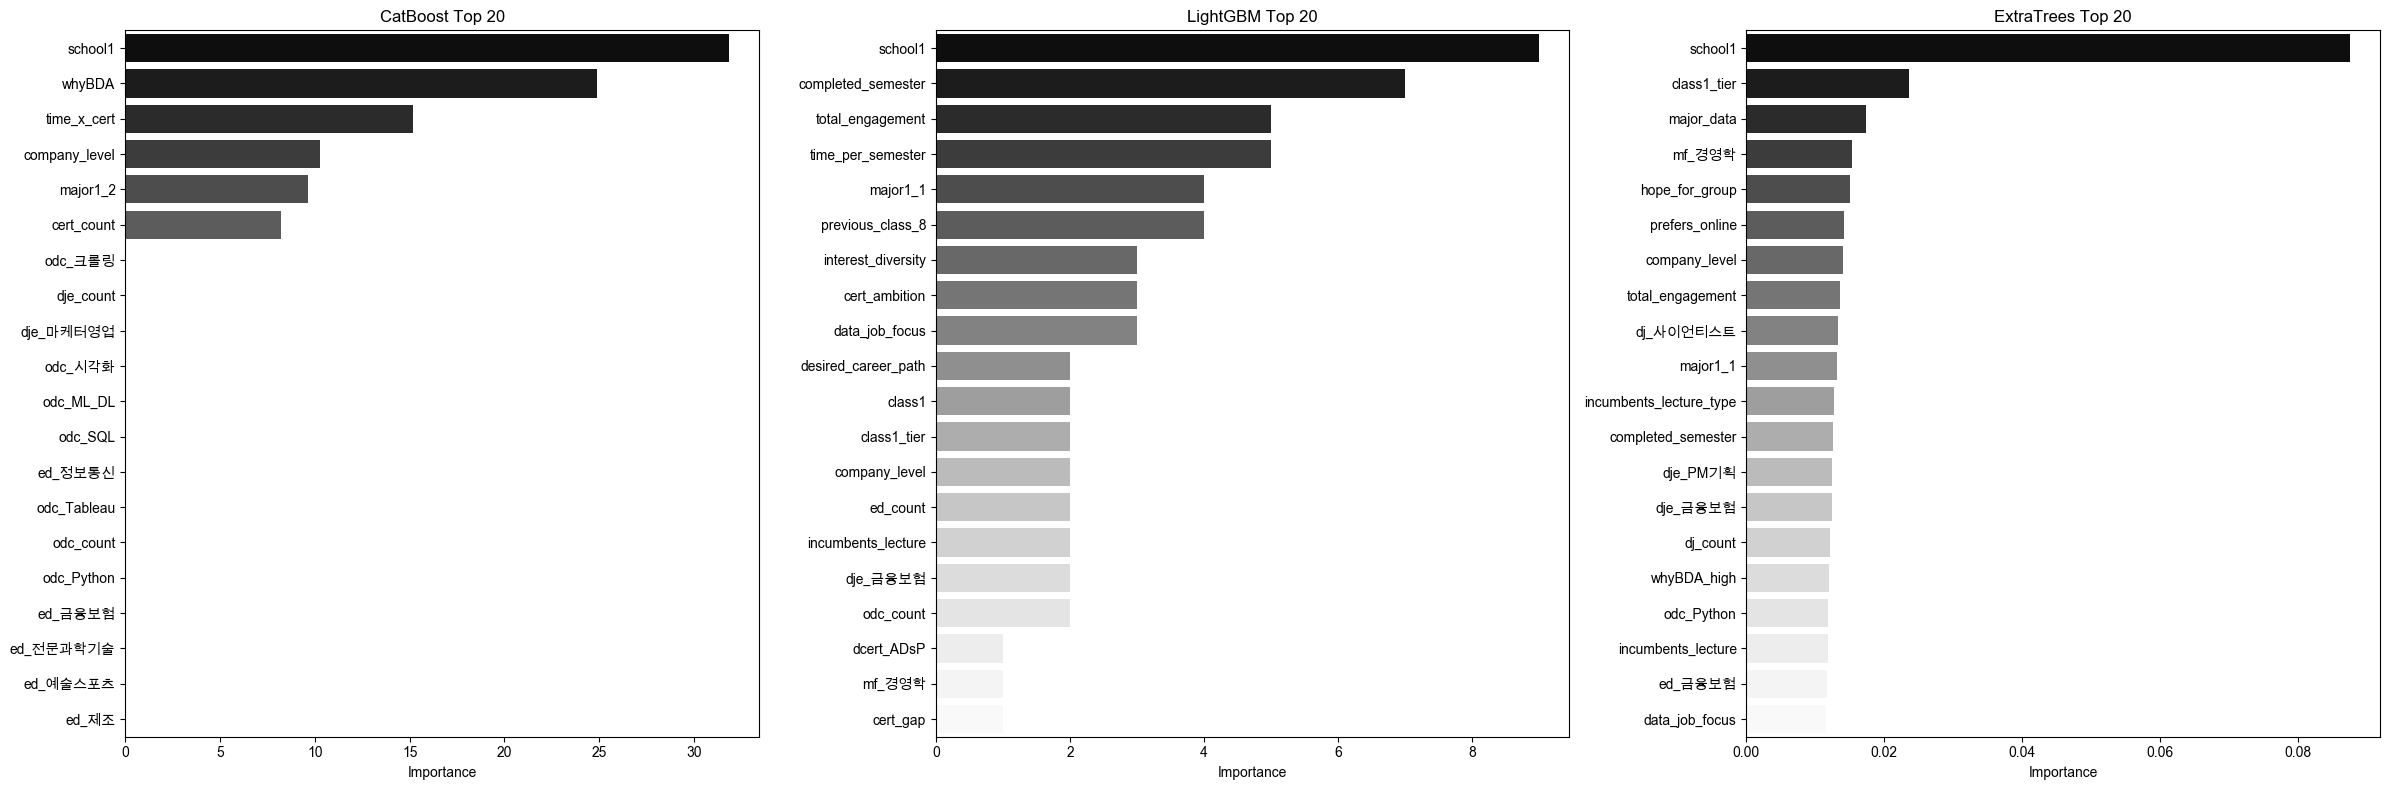

,feature,group,CatBoost,LightGBM,ExtraTrees
0,company_level,Top_20,10.250580,2,0.013997
1,school1,Top_20,31.838102,9,0.087543
2,cert_컴퓨터활용능력,Bottom_30,0.000000,0,0.000541
3,mf_경제통상학,Bottom_30,0.000000,0,0.002635
4,mf_교육학,Bottom_30,0.000000,0,0.001450
5,mf_법학,Bottom_30,0.000000,0,0.000135
6,mf_예체능,Bottom_30,0.000000,0,0.002396
7,mf_의약학,Bottom_30,0.000000,0,0.000699
8,prev_8_level,Bottom_30,0.000000,0,0.004033


In [22]:
common_df_4, imp_dfs_4 = feature_importance(
    comparator=comparator_v4,
    X=X_v4,
    model_indices=top3_idx,
    model_names=top3,
    top_n=20,
    bottom_n=30
)

plot_importance(
    imp_dfs=imp_dfs_4,
    model_names=top3,
    top_n=20,
    palette='Grays_r'
)

common_df_4

### Version 5

- Add features

In [ ]:
from src.preprocess import Pipeline

pipe = Pipeline(config={'skip_steps': ['encode_text_embeddings']})
tr_5, te_5, tid_5 = pipe.run(train, test)

X_v5 = tr_5.drop(columns=v4_drop_cols)
test_v5 = te_5.drop(columns=zero_common_list + ['nationality'])

[fill_na] 결측치 처리 완료
[fix_completed_semester] completed_semester 처리 완료
[map_major] major 매핑 완료 (test only)
[drop_useless] ['generation', 'contest_award', 'idea_contest', 'contest_participation'] 제거 완료
[encode_certs] 자격증 인코딩 완료
[encode_companies] 기업 카테고리 인코딩 완료
[encode_multi_hot] multi-hot 인코딩 완료
[encode_text_embeddings] 건너뜀
[drop_originals] 원본 컬럼 제거 완료
[create_features] 파생변수 23개 생성 완료
Preprocessing completed: train (748, 126), test (814, 125)


In [24]:
def _last_prev_gen(row): 
    for gen in [8, 7, 6, 5, 4, 3]:
        col = f'previous_class_{gen}'       
        if col in row.index and row[col] != '해당없음':
            return gen
    return 0                                                                                                     

def _prev_gap(row):                                                                                              
    attended = [g for g in [3, 4, 5, 6, 7, 8]                                                                  
                if f'previous_class_{g}' in row.index
                and row[f'previous_class_{g}'] != '해당없음']
    if len(attended) < 2:
        return 0
    return (max(attended) - min(attended) + 1) - len(attended)

for df in [X_v5, test_v5]:
    # 텍스트 성의 지수
    df['whyBDA_len']     = df['whyBDA'].fillna('').str.len()
    df['wtg_len']        = df['what_to_gain'].fillna('').str.len()
    df['total_text_len'] = df['whyBDA_len'] + df['wtg_len']

    # 이전 기수 최근성 & 공백
    df['last_prev_gen'] = df.apply(_last_prev_gen, axis=1)
    df['prev_gap']      = df.apply(_prev_gap, axis=1)

    # 전공-직무 일치도
    major_int = df['major_data'].astype(int) if 'major_data' in df.columns else 0
    df['major_job_match'] = ((major_int == 1) & (df['data_job_focus'] > 0)).astype(int)

    # 핵심 기술 관심 조합
    odc_p = df['odc_Python'] if 'odc_Python' in df.columns else 0
    odc_m = df['odc_ML_DL']  if 'odc_ML_DL'  in df.columns else 0
    odc_s = df['odc_SQL']    if 'odc_SQL'    in df.columns else 0
    df['core_skill_interest'] = odc_p + odc_m + odc_s
    df['full_stack_interest'] = (df['core_skill_interest'] == 3).astype(int)

    # 시간 집중도
    df['time_focus_score'] = df['time_input'] / (df['dj_count'] + 1)

    # 충성 × 역량
    df['loyal_advanced'] = df['loyal_member'] * df['prev_max_level']

print(f"\nFeature: {X_v4.shape[1]} → {X_v5.shape[1]}")
print(f"X_v5: {X_v5.shape}, y: {y.shape}, test_v5: {test_v5.shape}")


Feature: 120 → 130
X_v5: (748, 130), y: (748,), test_v5: (814, 130)


In [25]:
comparator_v5 = ModelComparator(n_splits=10)
result_v5 = comparator_v5.run(X_v5, y, pipeline=pipe)
result_v5

LightGBM: 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


  → LightGBM: OOF F1=0.4655, Mean Fold F1=0.4836±0.0246, Threshold=0.27


XGBoost: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


  → XGBoost: OOF F1=0.4119, Mean Fold F1=0.439±0.0593, Threshold=0.1


CatBoost: 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


  → CatBoost: OOF F1=0.4727, Mean Fold F1=0.4871±0.0363, Threshold=0.39


RandomForest: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


  → RandomForest: OOF F1=0.4607, Mean Fold F1=0.4967±0.0298, Threshold=0.3


ExtraTrees: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]

  → ExtraTrees: OOF F1=0.4633, Mean Fold F1=0.5053±0.0465, Threshold=0.21


,name,oof_f1,mean_fold_f1,std_fold_f1,best_threshold
0,CatBoost,0.4727,0.4871,0.0363,0.39
1,LightGBM,0.4655,0.4836,0.0246,0.27
2,ExtraTrees,0.4633,0.5053,0.0465,0.21
3,RandomForest,0.4607,0.4967,0.0298,0.30
4,XGBoost,0.4119,0.4390,0.0593,0.10


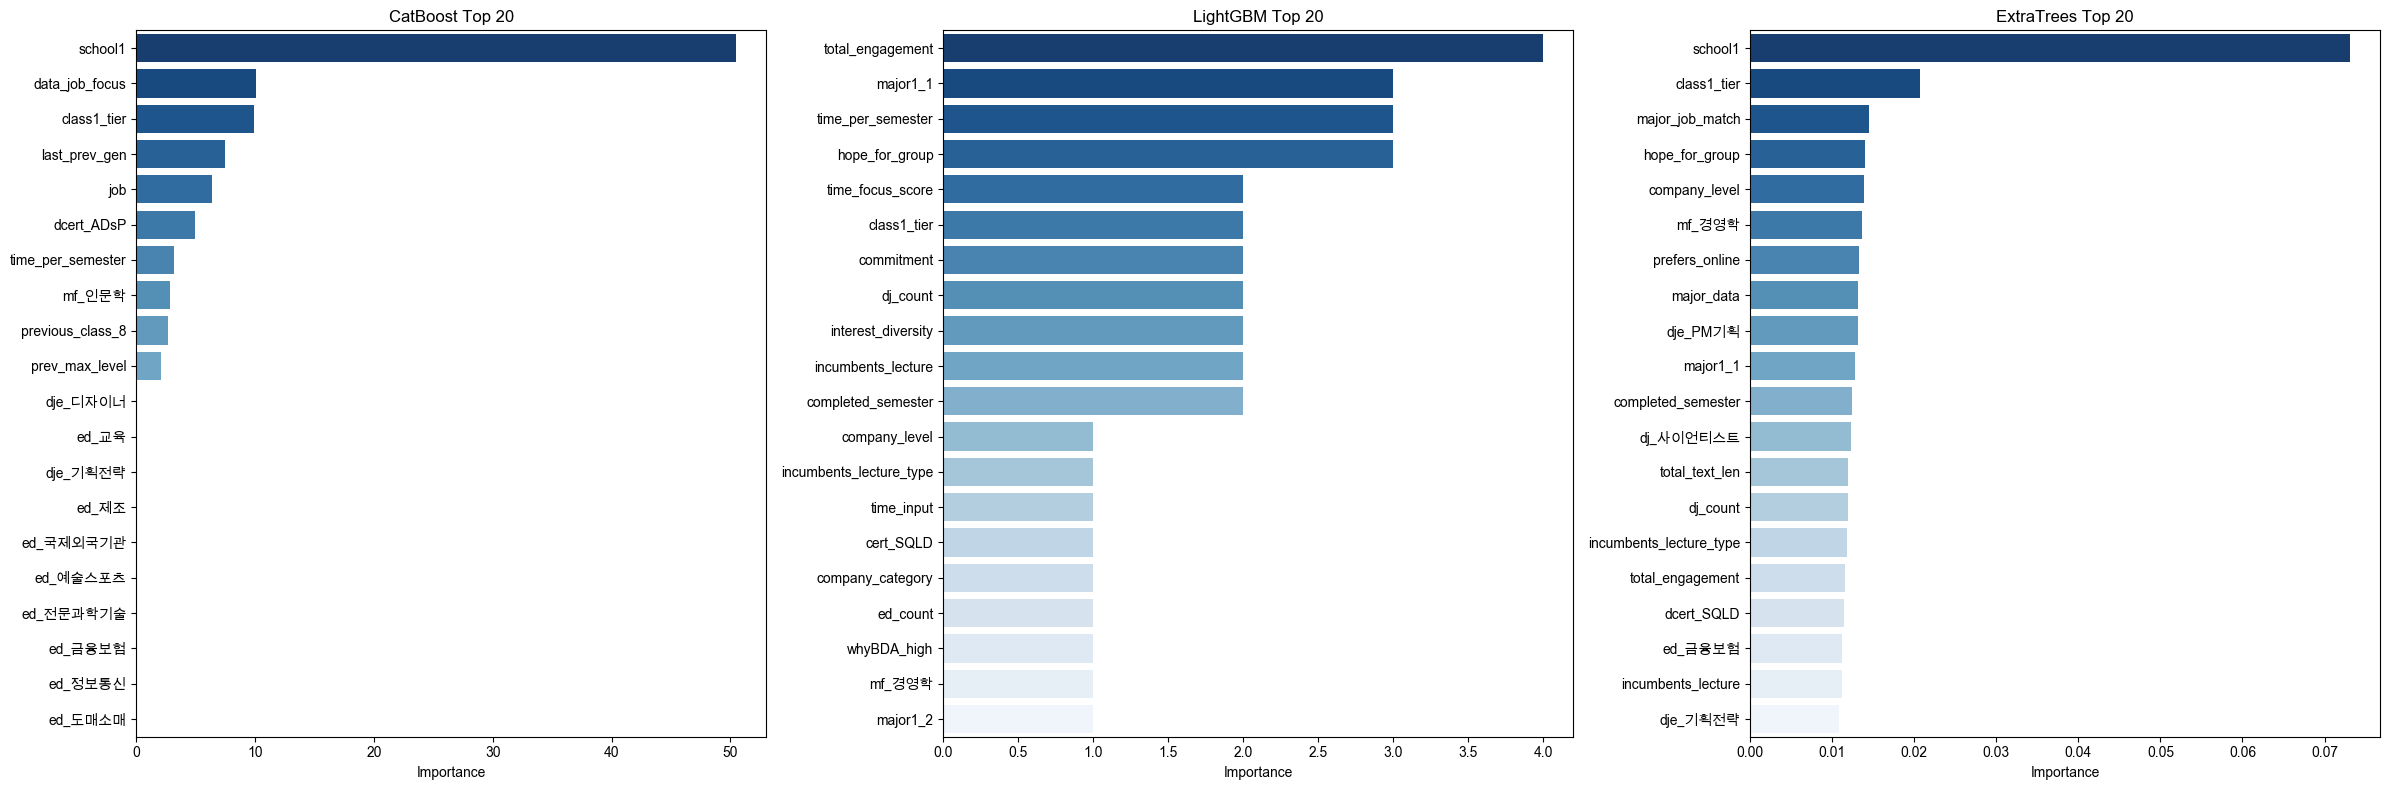

,feature,group,CatBoost,LightGBM,ExtraTrees
0,class1_tier,Top_20,9.942869,2,0.020730
1,dj_연구자,Bottom_30,0.000000,0,0.002570
2,loyal_advanced,Bottom_30,0.000000,0,0.003676
3,mf_경제통상학,Bottom_30,0.000000,0,0.002816
4,mf_교육학,Bottom_30,0.000000,0,0.001285
5,mf_법학,Bottom_30,0.000000,0,0.000119
6,mf_예체능,Bottom_30,0.000000,0,0.002725
7,mf_의약학,Bottom_30,0.000000,0,0.000579


In [27]:
common_df_5, imp_dfs_5 = feature_importance(
    comparator=comparator_v5,
    X=X_v5,
    model_indices=top3_idx,
    model_names=top3,
    top_n=20,
    bottom_n=30
)

plot_importance(
    imp_dfs=imp_dfs_5,
    model_names=top3,
    top_n=20,
    # palette='Grays_r'
)

common_df_5

정규성 만족 비율: 0.0% → SPEARMAN 선택


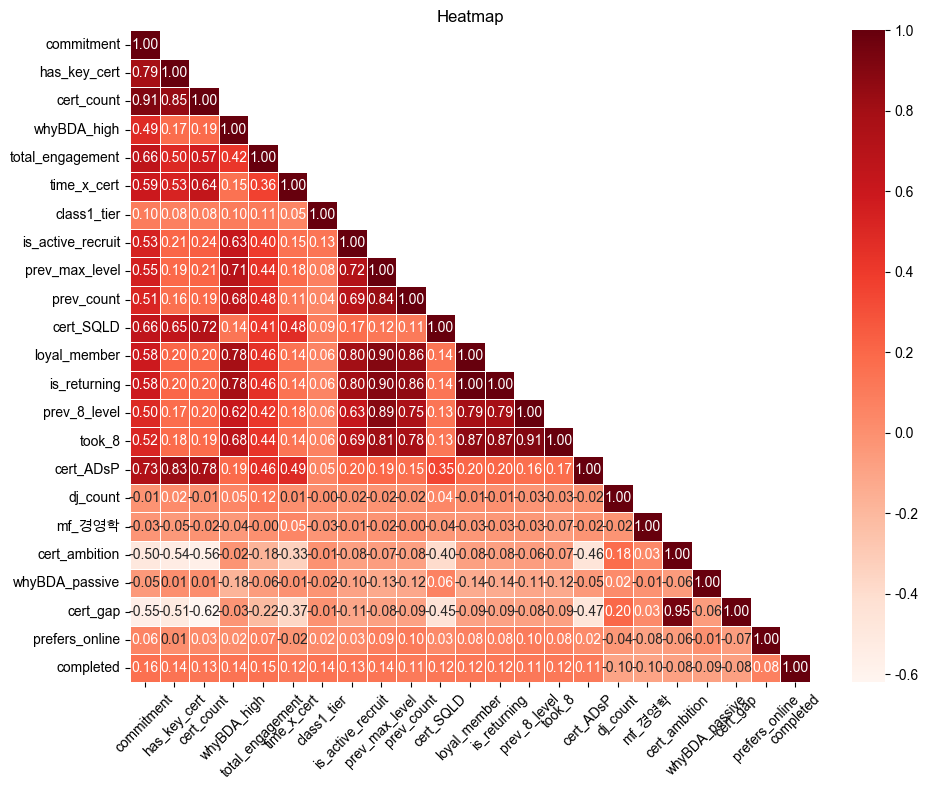

,column,method,correlation,p_value,abs_corr,significant
0,commitment,spearman,0.1630,0.0000,0.1630,True
1,has_key_cert,spearman,0.1441,0.0001,0.1441,True
2,cert_count,spearman,0.1428,0.0001,0.1428,True
3,whyBDA_high,spearman,0.1391,0.0001,0.1391,True
4,total_engagement,spearman,0.1391,0.0001,0.1391,True
5,time_x_cert,spearman,0.1364,0.0002,0.1364,True
6,class1_tier,spearman,0.1358,0.0002,0.1358,True
7,is_active_recruit,spearman,0.1303,0.0004,0.1303,True
8,prev_max_level,spearman,0.1294,0.0004,0.1294,True
9,prev_count,spearman,0.1268,0.0005,0.1268,True


In [28]:
from src.preprocess.eda import AdvanceEDA
from src.visualization.plot import heatmap_plot 

corr_df = AdvanceEDA.check_correlation(
    tr_5.drop(columns=zero_common_list + ['nationality']), 
    target='completed', 
    method='auto'
    )
true_corr = corr_df[corr_df['significant'] == True]                                                              
true_corr_cols = true_corr['column'].tolist()                                                                    

heatmap_plot(tr_5[true_corr_cols + ['completed']], mask='upper', cmap='Reds')
true_corr.reset_index(drop=True)

In [29]:
from src.models import Tuner

MODEL = 'catboost'
N_TRIALS = 500

tuner_v5 = Tuner(MODEL, X_v5, y, pipeline=pipe, n_trials=N_TRIALS)
study_v5 = tuner_v5.run()

  0%|          | 0/500 [00:00<?, ?it/s]

Best F1: 0.5191
Best params: {'iterations': 1557, 'learning_rate': 0.12350606560690923, 'depth': 10, 'l2_leaf_reg': 6.1302833328352335, 'border_count': 49, 'min_data_in_leaf': 53, 'subsample': 0.3368898496796942, 'colsample_bylevel': 0.7699408866329964, 'scale_pos_weight': 3.1707298343788413, 'random_strength': 9.548929852548003, 'bagging_temperature': 3.2443056169827176, 'random_seed': 42, 'verbose': 0, 'eval_metric': 'F1'}


In [31]:
from src.models import predict_params

oof, test_probs, best_t = predict_params(
    MODEL, tuner_v5.best_params,
    X_v5, y, test_v5, tid_5,
    pipeline=pipe,
    version=f'{MODEL}_tuning_v5'
)

OOF F1: 0.5191, Threshold: 0.51
Saved: submissions/catboost_tuning_v5.csv
Class 분포:
completed
1    568
0    246
Name: count, dtype: int64
